# Higgs Inflation with Ultra-Slow-Roll (USR)

This notebook explores the possibility of realizing **Ultra-Slow-Roll (USR)** dynamics within the context of Higgs Inflation. USR is characterized by a rapid decrease in the slow-roll parameter $\epsilon$ (where $\eta \approx -3$ or larger), leading to a significant enhancement of the scalar power spectrum. This is crucial for producing Primordial Black Holes (PBHs).

## Strategy
To achieve this in a single-field model, we typically need a feature in the potential (like an inflection point). We will introduce a modification to the standard Higgs potential:
$$ V(\phi) = V_{\text{Higgs}}(\phi) \cdot (1 + A \cdot e^{-\frac{(\phi - \phi_0)^2}{2\sigma^2}}) $$
where the Gaussian bump/dip creates a temporary flattening of the potential.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from inflation_models import InflationModel, HiggsModel
from inf_dyn_background import run_background_simulation, get_derived_quantities
from inf_dyn_MS_full import run_ms_simulation, get_ms_derived_quantities
from inf_dyn_plot import set_style, plot_background_n_vs_t, plot_eps_h

set_style()

## 1. Defining the USR Higgs Model

We subclass `HiggsModel` to add a localized perturbation to the potential. We need to be careful with analytical derivatives.

In [2]:
class USRHiggsModel(InflationModel):
    def __init__(self, A_bump=0.1, phi0=3.0, sigma=0.1):
        super().__init__("Higgs with USR Feature")
        self.alpha = np.sqrt(2/3)
        self.v0 = (1.5e-5)**2
        self.xi = 5.5
        # Perturbation parameters
        self.A_bump = A_bump
        self.phi0 = phi0
        self.sigma = sigma

    def f_base(self, x):
        return (1 - np.exp(-self.alpha * x))**2

    def df_base(self, x):
        return 2 * self.alpha * np.exp(-self.alpha * x) * (1 - np.exp(-self.alpha * x))

    def d2f_base(self, x):
        return 2 * self.alpha**2 * np.exp(-self.alpha * x) * (2 * np.exp(-self.alpha * x) - 1)
    
    # Modification Factor G(x) = 1 + A * exp(...)
    def G(self, x):
        return 1 + self.A_bump * np.exp(-(x - self.phi0)**2 / (2 * self.sigma**2))
    
    def dG(self, x):
        # Derivative of gaussian factor
        arg = -(x - self.phi0)**2 / (2 * self.sigma**2)
        return self.A_bump * np.exp(arg) * (-(x - self.phi0) / self.sigma**2)
        
    def d2G(self, x):
        arg = -(x - self.phi0)**2 / (2 * self.sigma**2)
        pre = self.A_bump * np.exp(arg)
        term1 = (-(x - self.phi0) / self.sigma**2)**2
        term2 = -1 / self.sigma**2
        return pre * (term1 + term2)

    # Full Potential F(x) = f_base(x) * G(x)
    def f(self, x):
        return self.f_base(x) * self.G(x)

    def dfdx(self, x):
        return self.df_base(x) * self.G(x) + self.f_base(x) * self.dG(x)

    def d2fdx2(self, x):
        return (self.d2f_base(x) * self.G(x) + 
                2 * self.df_base(x) * self.dG(x) + 
                self.f_base(x) * self.d2G(x))

# Instantiate models
std_higgs = HiggsModel()
# Tuning A_bump < 0 usually creates a dip/inflection point
usr_higgs = USRHiggsModel(A_bump=-0.05, phi0=2.0, sigma=0.3) 

## 2. Visualize Potential Modification

We compare the standard Higgs potential with our modified one to ensuring the feature is located correctly (e.g., around $\phi \sim 2$ where scales are relevant).

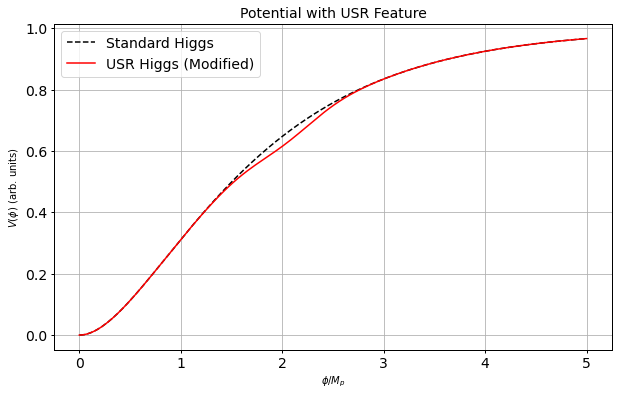

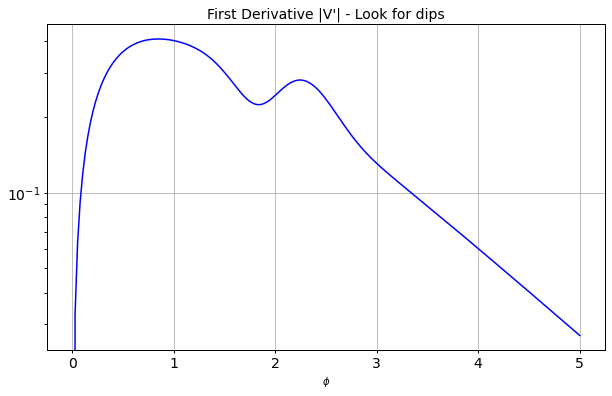

In [3]:
phi = np.linspace(0, 5, 200)

plt.figure(figsize=(10, 6))
plt.plot(phi, std_higgs.f(phi), 'k--', label='Standard Higgs')
plt.plot(phi, usr_higgs.f(phi), 'r-', label='USR Higgs (Modified)')
plt.xlabel(r"$\phi / M_p$")
plt.ylabel(r"$V(\phi)$ (arb. units)")
plt.title("Potential with USR Feature")
plt.legend()
plt.grid(True)
plt.show()

# Derivative check - Look for flatness (derivative -> 0)
plt.figure(figsize=(10, 6))
plt.plot(phi, np.abs(usr_higgs.dfdx(phi)), 'b-')
plt.yscale('log')
plt.title("First Derivative |V'| - Look for dips")
plt.xlabel(r"$\phi$")
plt.grid(True)
plt.show()

## 3. Background Dynamics Check

We run the simulation. If USR is achieved, we should see a violation of slow-roll, specifically $\eta_H$ becoming large (order -3 or -6) near the feature.

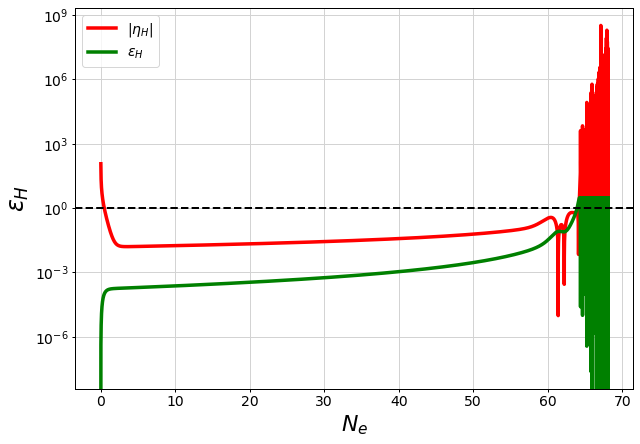

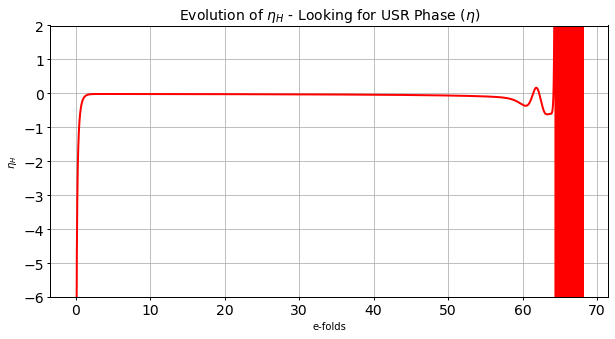

In [4]:
T_span = np.linspace(0, 5000, 100000)
sol_usr = run_background_simulation(usr_higgs, T_span)
derived_usr = get_derived_quantities(sol_usr, usr_higgs)

# Plot Slow Roll Parameters
plot_eps_h(derived_usr['N'], derived_usr['epsH'], derived_usr['etaH'])

# Zoom in on etaH behavior
plt.figure(figsize=(10, 5))
plt.plot(derived_usr['N'], derived_usr['etaH'], 'r-', lw=2)
plt.xlabel("e-folds")
plt.ylabel(r"$\eta_H$")
plt.title("Evolution of $\eta_H$ - Looking for USR Phase ($\eta \approx -3$)")
plt.grid()
plt.ylim(-6, 2)
plt.show()

## 4. Power Spectrum Enhancement

We select a mode $k$ that exits the horizon exactly during the USR phase and calculate its power spectrum. We expect a significant boost compared to the standard model.

In [ ]:
# Identify N where feature is crossed
# This corresponds roughly to where etaH dips
idx_feature = np.argmin(derived_usr['etaH'])
k_feature = derived_usr['aH'][idx_feature]

print(f"Feature crossed at N approx {derived_usr['N'][idx_feature]:.2f}")
print(f"Feature scale k = {k_feature:.4e}")

# Run MS simulation for this mode
# N.B. This might be numerically stiff due to the feature
T_pert = np.linspace(0, T_span[idx_feature]*2.0, 5000)
sol_ms_usr = run_ms_simulation(usr_higgs, T_pert, k_feature)
res_usr = get_ms_derived_quantities(sol_ms_usr, usr_higgs, k_feature)

# Compare with standard higgs at same k (approx)
sol_ms_std = run_ms_simulation(std_higgs, T_pert, k_feature)
res_std = get_ms_derived_quantities(sol_ms_std, std_higgs, k_feature)

plt.figure(figsize=(10, 6))
plt.loglog(res_usr['aHk'], res_usr['P_S'], 'b-', lw=3, label='USR Higgs P_S')
plt.loglog(res_std['aHk'], res_std['P_S'], 'k--', lw=2, label='Standard Higgs P_S')
plt.xlabel('aH/k')
plt.ylabel('Power Spectrum $P_\zeta$')
plt.title(f'Power Spectrum Enhancement at k={k_feature:.2e}')
plt.legend()
plt.grid(True)
plt.show()

Feature crossed at N approx 67.94
Feature scale k = 5.8155e+20
